#### Combine right and left hemispheres in mega matrix to rule them all

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
import seaborn as sns
import matplotlib.font_manager

In [20]:
import sys
utils_dir = '/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/code/streams/utils/'
sys.path.append(utils_dir)
from rsm_utils import get_flat_lower_tri, make_flat_rsms

In [2]:
def get_lower_tri(x, with_diagonal=False):
    """
    Returns the lower triangle of a provided matrix
    Inputs
        x (np.ndarray): 2D matrix to get triangle from
        with_diagonal (bool): if True, keeps the diagonal as part of lower triangle
    """
    k = 0 if with_diagonal else -1
    return x[np.tril_indices_from(x, k=k)]

In [3]:
## Set plotting params
sns.set(rc={
             'axes.axisbelow': False,
             'axes.edgecolor': 'lightgrey',
             'axes.facecolor': 'None',
             'axes.grid': False,
             'axes.spines.right': False,
             'axes.spines.top': False,
             'figure.facecolor': 'white',
             'patch.edgecolor': 'w',
             'xtick.bottom': False,
             'xtick.direction': 'out',
             'xtick.top': False,
             'ytick.direction': 'out',
             'ytick.left': False,
             'ytick.right': False,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16})

In [4]:
data_dir = '../../../data/'
local_data_dir = '../../../local_data/'

subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']
n_repeats = 3

#threshold for voxels (based on split-half reliability)
thresh = .2

hemis = ['lh', 'rh']

In [5]:
both_flat_rsm = []

for hidx, hemi in enumerate(hemis):
    
    flat_rsm = make_flat_rsms(subjid, ROI_names, hemi, thresh)    
    both_flat_rsm.append(flat_rsm)  

In [6]:
r1_trial_order = [0, 0, 0, 1, 1, 1, 2, 2, 2]
r2_trial_order = [0, 1, 2, 0, 1, 2, 0, 1, 2]

#don't use same trials when same subject
ss_r1_trial_order = [0, 0, 1, 1, 2, 2]
ss_r2_trial_order = [1, 2, 0, 2, 0, 1]

In [7]:
total_combs = len(subjid) * (len(ROI_names)-1) * len(hemis)
total_combs/2

56.0

In [8]:
total_combs = len(subjid) * (len(ROI_names)-1) * len(hemis)
mega_matrix = np.zeros((total_combs,total_combs))

for i in range(total_combs): #rows - i.e. model candidate
    
    #take into account repeat of rois & subjects for 2 hemis
    if i < total_combs/2:
        idx = i
    else:
        idx = i - total_combs/2
    
    roi_idx1 = int(idx//8) #roi
    sidx1 = int(idx%8) #subject
    if i < total_combs/2:
        hidx1 = 0 #left hemi
    else:
        hidx1 = 1 #right hemi
    
    NC_model = np.zeros((6))
    
    #case 1 - t0 corrected by t1, compared to t2
    split_half = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,0],both_flat_rsm[hidx1][sidx1,roi_idx1,:,1])[0]
    NC_model[0] = split_half * 100
    
    #case 2 - t0 corrected by t2, compared to t1
    split_half = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,0],both_flat_rsm[hidx1][sidx1,roi_idx1,:,2])[0]
    NC_model[1] = split_half * 100
    
    #case 3 - t1 corrected by t2, compared to t0
    split_half = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,1],both_flat_rsm[hidx1][sidx1,roi_idx1,:,2])[0]
    NC_model[2] = split_half * 100
    
    #case 4 - t1 corrected by t0, compared to t2
    split_half = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,1],both_flat_rsm[hidx1][sidx1,roi_idx1,:,0])[0]
    NC_model[3] = split_half * 100
    
    #case 5 - t2 corrected by t1, compared to t0
    split_half = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,2],both_flat_rsm[hidx1][sidx1,roi_idx1,:,1])[0]
    NC_model[4] = split_half * 100
    
    #case 6 - t2 corrected by t0, compared to t1
    split_half = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,2],both_flat_rsm[hidx1][sidx1,roi_idx1,:,0])[0]
    NC_model[5] = split_half * 100
    
    for j in range(total_combs): #columns - i.e. target data
        #take into account repeat of rois & subjects for 2 hemis
        if j < total_combs/2:
            jdx = j
        else:
            jdx = j - total_combs/2
            
        roi_idx2 = int(jdx//8) #roi
        sidx2 = int(jdx%8) #subject
        if j < total_combs/2:
            hidx2 = 0 #left hemi
        else:
            hidx2 = 1 #right hemi
        
        rsm_corr = np.zeros((6))
        #case1
        rsm_corr[0] = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,0],
                                     both_flat_rsm[hidx1][sidx2,roi_idx2,:,2])[0] * np.sqrt(100/NC_model[0])
        #case2
        rsm_corr[1] = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,0],
                                     both_flat_rsm[hidx1][sidx2,roi_idx2,:,1])[0] * np.sqrt(100/NC_model[1])
        #case3
        rsm_corr[2] = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,1],
                                     both_flat_rsm[hidx1][sidx2,roi_idx2,:,0])[0] * np.sqrt(100/NC_model[2])
        #case4
        rsm_corr[3] = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,1],
                                     both_flat_rsm[hidx1][sidx2,roi_idx2,:,2])[0] * np.sqrt(100/NC_model[3])
        #case5
        rsm_corr[4] = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,2],
                                     both_flat_rsm[hidx1][sidx2,roi_idx2,:,0])[0] * np.sqrt(100/NC_model[4])
        #case6
        rsm_corr[5] = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,2],
                                     both_flat_rsm[hidx1][sidx2,roi_idx2,:,1])[0] * np.sqrt(100/NC_model[5])
        
        mega_matrix[i,j] = np.mean(rsm_corr)

In [9]:
#save to local data folder
save_file = local_data_dir + 'processed/mega_mega_matrix_vSeparateData.data'

with open(save_file, 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump([mega_matrix], filehandle)


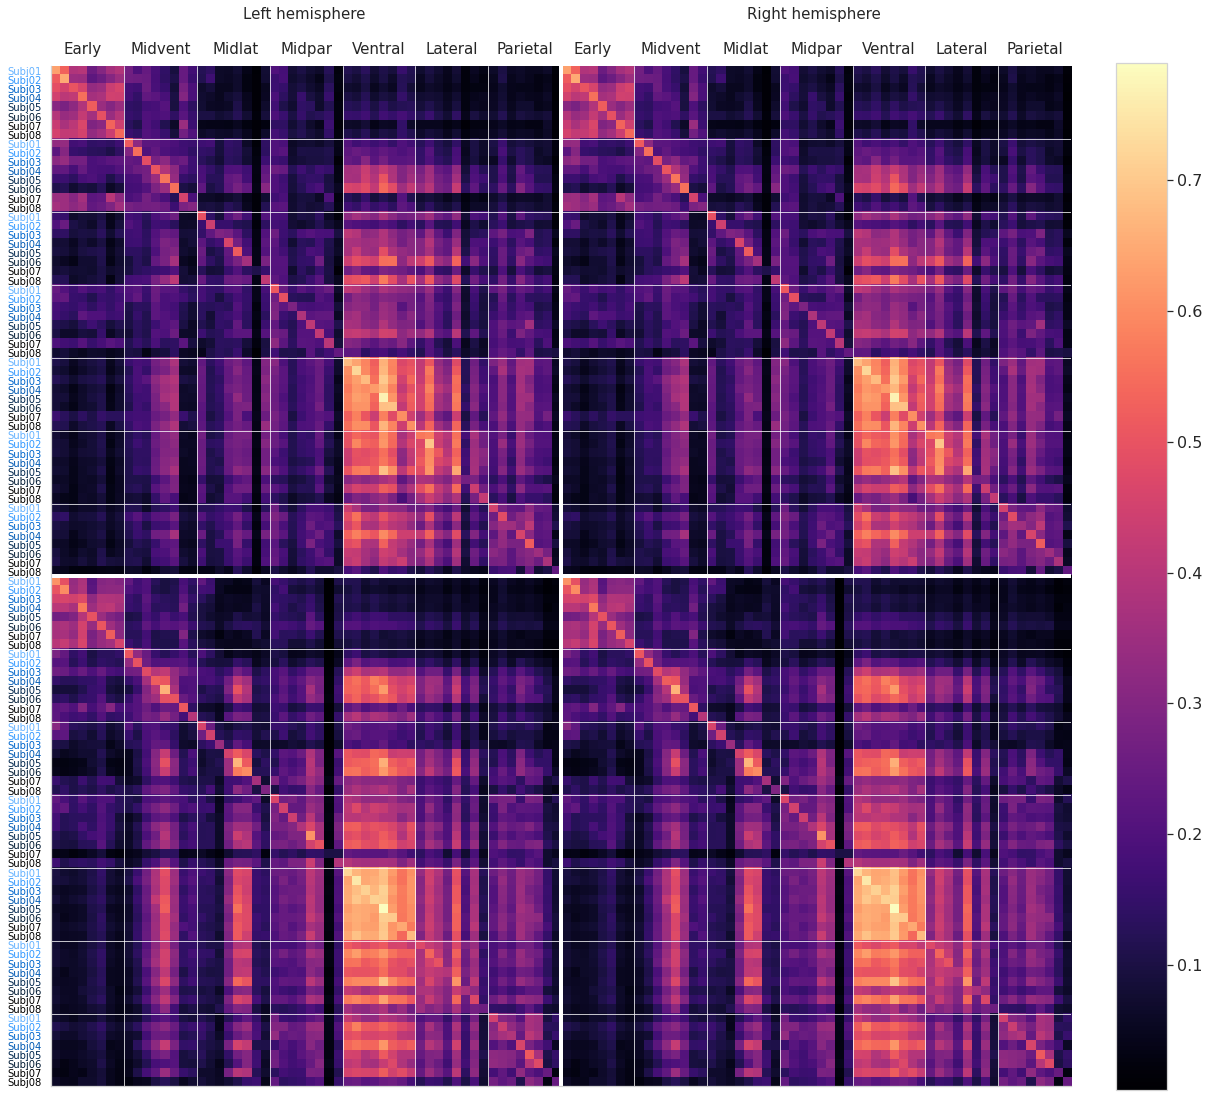

In [11]:
plt.figure(figsize=(20, 20))
plt.imshow(mega_matrix,
           cmap='magma')

y_labels = ['Subj01', 'Subj02', 'Subj03', 'Subj04', 'Subj05', 'Subj06', 'Subj07', 'Subj08']
x_labels = ['Left hemisphere \n \n', 'Early', 'Midvent', 'Midlat', 'Midpar', 'Ventral', 'Lateral', 'Parietal',
            'Right hemisphere \n \n', 'Early', 'Midvent', 'Midlat', 'Midpar', 'Ventral', 'Lateral', 'Parietal']

xlocs = np.array([27.5,3,11.5,19.75,27.5,35.5,43.5,51.5])
x_ticks= np.concatenate((xlocs,xlocs+56))
plt.xticks(x_ticks, x_labels, fontsize=15)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)

y_ticks = np.arange(0, total_combs)
plt.yticks(y_ticks, np.tile(y_labels, 2*7), fontsize='small')
colors = ['#66b3ff','#3399ff','#0066cc','#0059b3','#00264d','#001a33','#000000','#000000']
for i in range(total_combs):
    r = i%8
    plt.gca().get_yticklabels()[i].set_color(colors[r])

for l in range(13):
    if l == 6:
        plt.axvline(x=7.5 + l*8, c='w',linewidth=4)
        plt.axhline(y=7.5 + l*8, c='w',linewidth=4)
    else:
        plt.axvline(x=7.5 + l*8, c='w',linewidth=0.75)
        plt.axhline(y=7.5 + l*8, c='w',linewidth=0.75)

#plt.clim(0,1)
plt.colorbar(fraction=0.046, pad=0.04)

plt.savefig('../../../results/figures/megaMatrix_voxThresh' + str(int(thresh*100)) + '_vSeparateData_wholebrain.png')


In [13]:
regressor_indices = [
        np.hstack((np.repeat(1, 56), np.repeat(0, 56))), #hemisphere
        np.tile(np.tile(np.arange(8), 7),2),  # subjects
        np.tile(np.repeat(np.arange(7), 8),2),  # ROIs
        
    ]

regressors = []
view = []
for indices in regressor_indices:
    base = np.zeros((56*2, 56*2))
    xx, yy = np.meshgrid(indices, indices)
    base[xx == yy] = 1
    
    view.append(base)

    regressors.append(get_lower_tri(1 - base, with_diagonal=False))

Text(0.5, 1.0, 'ROI')

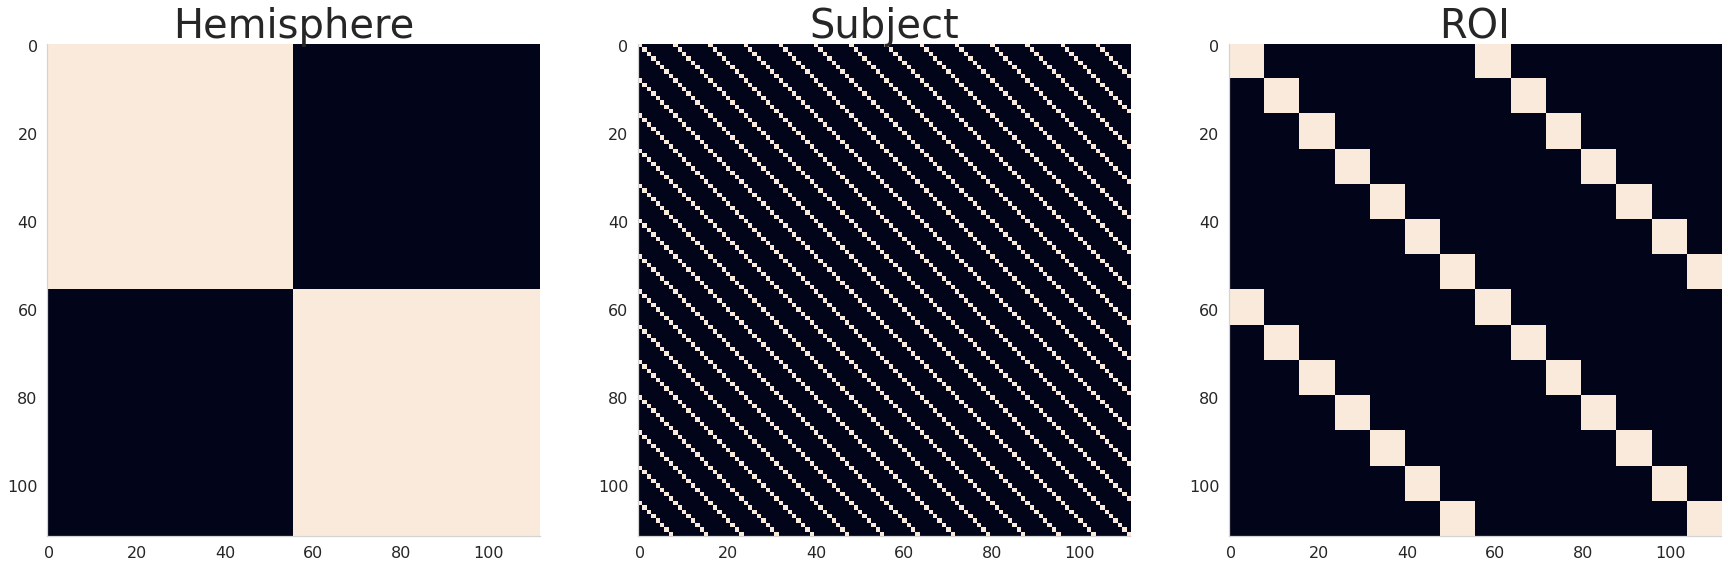

In [14]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3,figsize=(30,10))

ax0.imshow(view[0])
ax0.set_title('Hemisphere', fontsize=40)
ax1.imshow(view[1])
ax1.set_title('Subject', fontsize=40)
ax2.imshow(view[2])
ax2.set_title('ROI', fontsize=40)

In [15]:
mega_mega_RDM = get_lower_tri(1 - mega_matrix, with_diagonal=False)

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats

X = np.array([x.flatten() for x in regressors]).T
y = mega_mega_RDM

In [17]:
reg = LinearRegression().fit(X, y)

In [18]:
reg.coef_

array([-0.00723499,  0.0382361 ,  0.14559288])

In [19]:
X2 = sm.add_constant(X) #fit intercept

est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     290.9
Date:                Tue, 12 Jan 2021   Prob (F-statistic):          1.02e-176
Time:                        10:37:33   Log-Likelihood:                 3608.5
No. Observations:                6216   AIC:                            -7209.
Df Residuals:                    6212   BIC:                            -7182.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6338      0.007     89.048      0.0